In [ ]:
!pip install kagglehub

In [1]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", path)

c:\Users\USER\miniconda3\envs\imgcap\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\USER\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1


In [2]:
# 데이터 확인
import os
print(os.listdir(path))
# captions.txt 파일 읽기
# import pandas as pd
captions_path = os.path.join(path, "captions.txt")
print(captions_path)

['captions.txt', 'Images']
C:\Users\USER\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\captions.txt


In [3]:
# Images 의 폴더의 파일 목록 확인
images_path = os.path.join(path, "Images")
print(os.listdir(images_path))

['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg', '1007320043_627395c3d8.jpg', '1009434119_febe49276a.jpg', '1012212859_01547e3f17.jpg', '1015118661_980735411b.jpg', '1015584366_dfcec3c85a.jpg', '101654506_8eb26cfb60.jpg', '101669240_b2d3e7f17b.jpg', '1016887272_03199f49c4.jpg', '1019077836_6fc9b15408.jpg', '1019604187_d087bf9a5f.jpg', '1020651753_06077ec457.jpg', '1022454332_6af2c1449a.jpg', '1022454428_b6b660a67b.jpg', '1022975728_75515238d8.jpg', '102351840_323e3de834.jpg', '1024138940_f1fefbdce1.jpg', '102455176_5f8ead62d5.jpg', '1026685415_0431cbf574.jpg', '1028205764_7e8df9a2ea.jpg', '1030985833_b0902ea560.jpg', '103106960_e8a41d64f8.jpg', '103195344_5d2dc613a3.jpg', '103205630_682ca7285b.jpg', '1032122270_ea6f0beedb.jpg', '1032460886_4a598ed535.jpg', '1034276567_49bb87c51c.jpg', '104136873_5b5d41be75.jpg', '1042020065_fb3d3ba5ba.jpg', '1042590306_95dea0916c.jpg', '1045521051_108ebc19b

In [16]:
!pip install pandas

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 11.6/11.6 MB 72.7 MB/s eta 0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

   ---------------------------------------- 0/3 [pytz]
   ---------------------------------------- 0/3 [pytz]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ---------

In [4]:
# captions.txt 파일 내용을 pandas DataFrame으로 읽기
import pandas as pd
captions_df = pd.read_csv(captions_path)
# DataFrame의 첫 5개 행 출력    
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
!pip install torchvision

In [ ]:
!pip install matplotlib

In [5]:
# 토큰화(단어)
# 필요 라이브러리 설치
import pandas as pd
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import os
import re
from tqdm import tqdm

In [6]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
import unicodedata

In [8]:
# 전처리 함수 정의
    # 유니코드 문자열을 ASCII로 변환  NFD(Normal From Decompostion) 방식으로 분해
    # 비문자(숫자 특수기호) 제거
    # 불필요한 기호 제거
    # 양끝 공백 제거
def preprocess_text(text):
    context = ''
    # NFD(Normal From Decompostion) 방식으로 분해
    for ch in unicodedata.normalize('NFD', text):        
        if unicodedata.category(ch) != 'Mn':  # Mark, Nonspacing 'Mn'은 결합 문자(예: 악센트)로 분해된 문자
            # 'Mn'이 아닌 문자만 context에 추가
            context += ch

    context = context.lower()  # 소문자로 변환
    context = re.sub(r'[^a-z!?,]+', ' ', context)  # 비문자(숫자 특수기호) 제거
    return context.strip()  # 양끝 공백 제거


In [9]:
# caption 추출 : DataFrame에서 caption 열을 추출하고 전처리
captions = captions_df['caption'].apply(preprocess_text).tolist()
captions[100], captions_df['caption'][100]  #  전처리된 caption과 원본 caption 비교

('two different breeds of brown and white dogs play on the beach',
 'Two different breeds of brown and white dogs play on the beach .')

In [10]:
# 문장을 기반으로 어휘 사전을 구축하는 클래스 SOS EOS  중복되지 않도록 단어들을 추가
# 클래스명 Vocab
class Vocab:
    def __init__(self):
        self.word2idx = {'<SOS>': 0, '<EOS>': 1}  # 시작 토큰과 종료 토큰
        self.idx2word = {0: '<SOS>', 1: '<EOS>'}
        self.word2count = {}
        self.nwords = 2

    def build_vocab(self, captions):
        for word in captions.split():
            if word not in self.word2idx:
                self.word2idx[word] = self.nwords
                self.idx2word[self.nwords] = word
                self.word2count[word] = 1
                self.nwords += 1
            else:
                self.word2count[word] += 1      
# 단어 사전 생성
vocab = Vocab()
for caption in captions:
    vocab.build_vocab(caption)
# 단어 사전의 크기
print("Vocabulary size:", vocab.nwords)
# 단어 빈도수 상위 10개 출력
print("Top 10 words:", sorted(vocab.word2count.items(), key=lambda x: x[1], reverse=True)[:10])

Vocabulary size: 8446
Top 10 words: [('a', 62992), ('in', 18986), ('the', 18419), ('on', 10745), ('is', 9345), ('and', 8862), ('dog', 8138), ('with', 7765), ('man', 7274), ('of', 6723)]


In [11]:
# dataset 을 만들기위한 Custom Dataset 클래스 정의
# 이미지경로, 이미지파일명,캡션리스트,단어사전,맥스길이
# 클래스명 : CustomDataset
class CustomDataset(Dataset):
    def __init__(self, images_dir_path, img_filenames_list, captions, vocab, max_length=75):
        self.images_dir_path = images_dir_path
        self.img_filenames_list = img_filenames_list
        self.captions = captions
        self.vocab = vocab
        self.length = len(img_filenames_list)
        self.trasform = Compose([
            Resize((224, 224)),          
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.max_length = max_length
        
    def __len__(self):
        return self.length
    # 각 토큰을 고유한 숫자 식별자로 매핑하는 함수
    def _get_input_ids(self, sentence):
        input_ids = [0]*(self.max_length+2) 
        input_ids[0] = self.vocab.word2idx['<SOS>']  # <SOS> 토큰의 인덱스는 0
        input_ids[-1] = self.vocab.word2idx['<EOS>']
        for i, word in enumerate(sentence.split()):
            input_ids[i+1] = self.vocab.word2idx.get(word, 1)  # <EOS> 토큰의 인덱스는 1
        # torch 형태로 반환
        return torch.tensor(input_ids) #, dtype=torch.long)
    def __getitem__(self, index):
        imgfname,caption =  self.img_filenames_list[index], self.captions[index]
        imgfname = os.path.join(self.images_dir_path, imgfname)
        image = Image.open(imgfname)
        img = self.trasform(image)
        caption = self._get_input_ids(caption)
        return img, caption

In [ ]:
# vocab.idx2word

In [13]:
# 데이터 로더 생성
dataset = CustomDataset(images_path, captions_df['image'], captions, vocab)
# train dataset test dataset 분리
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [0.999, 0.001])  # 0.999 0.001
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# 데이터 수 확인
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 40415
Test dataset size: 40


In [14]:
# shape 확인
img, caption = next(iter(train_loader))
print("Image shape:", img.shape)
print("Caption shape:", caption.shape)

Image shape: torch.Size([64, 3, 224, 224])
Caption shape: torch.Size([64, 77])


In [15]:
# encoder 구성
class Encoder(nn.Module):
    def __init__(self, pretrained_feature_extractor):
        super(Encoder, self).__init__()
        self.pretrained_feature_extractor = pretrained_feature_extractor

    def forward(self, x):
        features = self.pretrained_feature_extractor(x)
        # 가중치중에서 fc 즉 분류기쪽만 가중치 업데이트를 하고 나머지 는 전부 freeze
        for name, param in self.pretrained_feature_extractor.named_parameters():
            if 'fc.weight' in name or 'fc.bias' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        return features

In [16]:
# 모델을 설계 및 학습(ResNet50 모델을 사용)
# ResNet50 의 마지막 레이어를 제거하고 특징 추출기로 사용하기위해 모델 구조 확인
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
# 구조 확인
# print(resnet)
# print([name for name,param in resnet.named_parameters()])
# 마지막 레이어를 변경
resnet.fc = nn.Linear(in_features=2048, out_features=1024)
encoder = Encoder(resnet).to(device)

In [17]:
# decode 구현  text 생성을 담당
# 인코더에서 추출된 이미지 특징을 바탕으로 순차적으로 생성해 나가는 시퀀스 생성 모델
# 임베딩 -> GRU->linear->Logsoftmax  예상되는 출력구조  단어분포(logsoftmax확률)
class Decoder(nn.Module):
    '''
    output_size  단어집합크기(vocab_size)
    embed_size 단어를 몇차원으로 임베딩할지 결정
    hidden_isze GRU의 hidden state
    '''
    def __init__(self, output_size, embed_size, hidden_size):
        super().__init__()
        # [batch, seq_len] -> [batch, seq_len,embed_size]
        self.e = nn.Embedding(num_embeddings=output_size,embedding_dim=embed_size)
        # 비선형 변환
        self.relu = nn.ReLU()
        # 순환계층
        # [ batch, seq_len, embed_size]
        self.gru = nn.GRU(embed_size,hidden_size,batch_first=True)
        # 출력계층
        self.ln = nn.Linear(hidden_size,output_size)
        self.lsoftmax = nn.LogSoftmax(dim=-1)
    def forward(self, x, prev_hidden):  # prev_hidden 이전 time step의 hidden stae(or inital state)
        x = self.e(x)  # 단어id -> 임베딩 벡터
        x = self.relu(x)
        output, hidden = self.gru(x,prev_hidden)
        y = self.ln(output)  # 단어분포를 벡터로 변환
        y = self.lsoftmax(y)
        return y,hidden


In [18]:
EMBEDED_SIZE = 300
HIDDEN_SIZE = 1024
decoder = Decoder(vocab.nwords, EMBEDED_SIZE,HIDDEN_SIZE).to(device)

In [19]:
vocab.nwords

8446

In [23]:
def train(epoch):
    encoder.train()
    decoder.train()
    losses = 0
    # 배치사이즈 만큼 데이터 가져옴
    for idx , (imgs,caption) in tqdm(enumerate(train_loader)):
        # 64,3,224,224 imgs
        # 64,77 caption
        imgs = imgs.to(device)
        caption = caption.to(device)
        extracted_features =  encoder(imgs)  #64 1024
        # extracted_features -> decoder_hidden  : [64,1024] -> [1,64,1024]
        decoder_hidden =  torch.reshape(extracted_features,(1,extracted_features.shape[0],-1 ))
        
        # caption[:, :-1]  다음문장 예측해야되서. 입력은 <sos> 단어,단어....
        # 다음 문장은 단어, 단어,,, <eos>
        # 캡션과 이미지 feature가 입력으로 들어감
        yhats, decoder_hidden =  decoder(caption[:, :-1],decoder_hidden)
        # 첫번째 단어를 제외
        gt = caption[:, 1:]
        # [batch, seq_len,vcab_size] -> (batch*seq_len, vocab_size)
        # 손실함수 NLLloss 입력형태로 변환 why? 최종 출력함수 logsoft 함수와 잘맞는 손실함수
        yhats_reshaped =  yhats.view(-1, yhats.shape[-1])
        gt = gt.reshape(-1)  # 평탄화  64, 72--> 94*72                
        loss = loss_fn(yhats_reshaped, gt)
        losses+=loss.item()
        
        opte.zero_grad()
        optd.zero_grad()

        loss.backward()
        opte.step()
        optd.step()
        if idx % 50 ==0:
            print(f'batch : {idx+1} loss = {losses / (idx+1)}')
    return losses / len(train_loader)

In [24]:
# 수치벡터를 문장으로 변환하는 함수
def ids2sentence(ids,vocab):
    sentence = ""
    for id in ids.squeeze():
        if id == 0:
            continue
        word = vocab.idx2word[id.item()]
        sentence += word + " "
        if id ==1 :
            break
    return sentence

In [ ]:
loss_fn = nn.NLLLoss(ignore_index=0).to(device)
optd = optim.Adam(decoder.parameters())
opte = optim.Adam(encoder.parameters())

n_epochs = 1
for i in range(n_epochs):
    print(f'epochs : {i+1} loss = {train(i+1)}')


In [ ]:
# 추론 inference
max_cap_length = 75
def eval_epoch():
    encoder.eval()
    decoder.eval()
    losses = 0
    with torch.no_grad():
        for i, (imgs, t_ids) in enumerate(test_loader):
            imgs = imgs.to(device) # 1 3 224 224
            t_ids = t_ids.to(device) # 1 77
            extracted_features = encoder(imgs)
            # 1 1 1024
            decoder_hidden =  torch.reshape(extracted_features,(1,extracted_features.shape[0],-1 ))
            input_ids = t_ids[:,0]  # sos 추출
            yhats = []
            pred_sentence = ''
            for j in range(1,max_cap_length+1):
                probs, decoder_hidden = decoder(input_ids.unsqueeze(0),decoder_hidden)
                yhats.append(probs)
                _,input_ids = torch.topk(probs,1,dim=-1)  # 확률이 가장 높은 단어 하나 선택
                input_ids = input_ids.squeeze(1).squeeze(1)                
                word = vocab.idx2word[input_ids.item()]
                pred_sentence += word + ' '
                if input_ids.item() == 1:
                    break
            gt_sentence = ids2sentence(t_ids,vocab)
            # 이미지 복원 transformer 가 정규화 한것을 복원  RGB
            img = imgs[0]
            img[0] = (img[0]*0.229)+0.485
            img[1] = (img[1]*0.229)+0.485
            img[2] = (img[2]*0.229)+0.485
            # c h w -> h w c  시각화를 위해서서
            plt.imshow(torch.permute(imgs[0],(1,2,0)).detach().cpu())
            print(f'정답 문장 : {gt_sentence}')
            print(f'모델 생성 문장 : {pred_sentence}')

            yhats_cat = torch.cat(yhats, dim=1)
            yhats_reshaped = yhats_cat.view(-1, yhats_cat.shape[-1])
            gt = t_ids[:,1:j+1]  # 실제 정답 (sos제외)
            gt = gt.view(-1)
            loss = loss_fn(yhats_reshaped, gt)
            losses += loss.item()            
        print("-"*100)
        return losses / len(test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039215386..1.0815775].


정답 문장 : two people are in a tent near a brick wall <EOS> 
모델 생성 문장 : a man is sitting on a large rock wall with a large white dog in the background of a large tent of a building with a large building in the background of a building with a large building in the background of a building with a red building in the background of the background of the background of the background of the background of the background of the background of the background of the background 
----------------------------------------------------------------------------------------------------
epochs : 1 loss = 0.17347074747085572


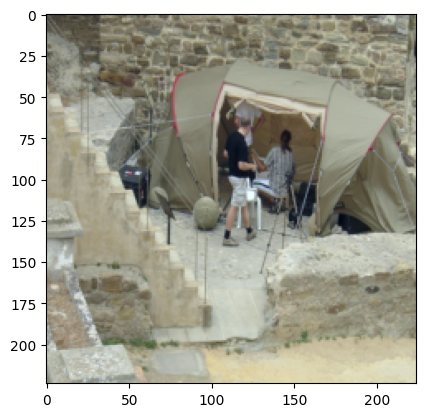

In [38]:
loss_fn = nn.NLLLoss(ignore_index=0).to(device)
optd = optim.Adam(decoder.parameters())
opte = optim.Adam(encoder.parameters())

n_epochs = 1
for i in range(n_epochs):
    print(f'epochs : {i+1} loss = {eval_epoch()}')